How well does a 1d ultra-simple stress fiber model replicate the formation of proto-z-disks?

Let's see

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches

To make things simple, we are going to treat the stress fiber as 1d, but composed of various "tracts" each track simulates a region in the radial cut through of the filament and can interact with neighboring tracts. We represent the tracts in a hexagonal coordinate system with each tract having access to each of the neighboring tracts. My favorite reference on this coordinate system is by a [games developer]. 

We use a cube cooordinate system, so our center hex is at (0,0,0) and we can find our neighboring hexes by moving up or down one in x, y, and z. We're going to create a bunch of hexagon math helper functions to use in our space.

[games developer]: https://www.redblobgames.com/grids/hexagons/

In [3]:
class HexMath:
    """Hexagonal coordinate helper functions, assuming pointy side up"""
    def cube_to_axial(i, j, k):
        """Convert cube coordinates to axial coordinates"""
        q, r = i, k
        return q, r
    
    def axial_to_cube(q, r):
        """Convert axial coordinates to cube coordinates"""
        i, k = q, r
        j = -i - k
        return i, j, k
    
    def cube_to_offset(i, j, k):
        """Convert cube coordinates to offset coordinates, odd rows shifted by +1/2 col"""
        col = i + (k-(k&1))//2
        row = k
        return col, row
    
    def offset_to_cart(col, row):
        """Convert offset coordinates (odd row shifted +1/2 col), into cartesian coordinates"""
        x = np.sqrt(3) * (col + 0.5 * (row&1))
        y = 3/2*row
        return x, y
    
    def axial_to_cart(q, r):
        """Convert axial coordinates into cartesian coordinates"""
        x = np.sqrt(3) * q + np.sqrt(3)/2 * r
        y = 3/2*r
        return x, y
    
    def cube_to_cart(i, j, k):
        """Convert cube coordinates to cartesian"""
        col, row = HexMath.cube_to_offset(i, j, k)
        x, y = HexMath.offset_to_cart(col, row)
        return x, y
    
    def cube_distance(i_1, j_1, k_1, i_2, j_2, k_2):
        """Distance between two hexagons in cube coordinates"""
        a = np.array((i_1, j_1, k_1))
        b = np.array((i_2, j_2, k_2))
        dist = np.sum(np.abs(np.subtract(a, b)))/2
        return dist
    
    def cube_within_radius(i, j, k, n, original=(0,0,0)):
        """Is this new location within a radius from an original (default origin)"""
        within_radius = HexMath.cube_distance(i, j, k, *original)<=n
        return within_radius

    def cube_validate(i, j, k):
        """Is this a valid cube coordinate?"""
        valid = (i + j + k) == 0
        return valid
    
    def cube_neighbors(i, j, k):
        """Give me a list of neighboring hexagons"""
        neighbors = [(i, j+1, k-1), (i+1, j, k-1), (i+1, j-1, k), 
                     (i, j-1, k+1), (i-1, j, k+1), (i-1, j+1, k)]
        return neighbors
    
    def cube_to_array_indices(i, j, k, n):
        """Convert cube coordinates to array location for a grid of radius n"""
        x = i + n
        y = k + n
        return x, y
    
    def create_grid_array(n):
        """Create a list of hex locations for a grid of radius n"""
        # Create grid
        scan = list(range(-n, n+1))
        grid = [[[] for q in scan] for r in scan]
        # Create tests to ensure location is within roi and valid
        within_radius = lambda i, j, k: HexMath.cube_within_radius(i, j, k, n)
        belongs = lambda ijk: within_radius(*ijk) and HexMath.cube_validate(*ijk)
        # Populate grid with coordinates
        for q, r in itertools.product(scan, scan):
            i, j, k = HexMath.axial_to_cube(q, r)
            if belongs((i,j,k)):
                x, y = HexMath.cube_to_array_indices(i,j,k,n)
                grid[x][y] = {'cube':(i,j,k)}
        grid = np.array(grid)
        return grid

A few of those are redundant for our purposes but we'll keep them around for flavor. With `HexMath` as support, it is a lot easier to create a space that tracks locations in a hexagonal grid, thus:

In [4]:
class TractSpace:
    """A spatial region of filaments/crosslinkers"""
    def __init__(self, size):
        """A hexagonal grid of a given symmetric radial size"""
        self.size = size
        self._tracts = HexMath.create_grid_array(size)
    
    def _OOB(self, x, y, z):
        """Is a location out of bounds for list storage?"""
        n = self.size
        return (x+n)>n or (y+n)>n or (z+n)>n
        
    def tract(self, i, j, k):
        """A single tract at cube coordinates"""
        n = self.size
        within = HexMath.cube_within_radius(i, j, k, n)
        valid = HexMath.cube_validate(i, j, k)
        if not within or not valid:
            return None #OOB
        x, y = HexMath.cube_to_array_indices(i, j, k, n)
        tract = self._tracts[x,y]
        return tract
    
    @property
    def all_tracts(self):
        """Give all the tracts back"""
        all_tracts = [tract for tract in self._tracts.flat if not tract == []]
        return all_tracts
    
    def neighbors(self, i, j, k):
        """Give me the neighbors, ignoring out of bounds"""
        if not HexMath.cube_within_radius(i, j, k, self.size):
            return None #OOB
        neighboring_coordinates = HexMath.cube_neighbors(i, j, k)
        tracts = [self.tract(i, j, k) for i, j, k in neighboring_coordinates if self.tract(i, j, k) is not None]
        return tracts
    
    def plot(self, callback=None):
        """Plot the tracts and what's in them, optionally using a callback"""
        #Set up callback 
        if callback is None:
            callback = lambda t: t['cube'] #default to cube coordinates
        #Set up figure 
        fig, ax = plt.subplots(1,1,figsize=(8,8))
        ax.axis('off')
        limit = 2*self.size+1
        ax.set(xlim=(-limit, limit), ylim=(-limit, limit), aspect=1)
        #Work through each tract
        for tract in self.all_tracts:
            x,y = HexMath.cube_to_cart(*tract['cube'])
            hex = matplotlib.patches.RegularPolygon((x,y), numVertices=6, 
                                                    radius=1, facecolor='White', 
                                                    edgecolor='k')
            ax.add_patch(hex)
            ax.text(x,y, str(callback(tract)), ha='center', va='center')
        plt.show()
        

In [5]:
space = TractSpace(2)
print("Single")
print(space.tract(0,-1,1))
print("Neighbors")
[print(t) for t in space.neighbors(0,0,0)]
print("All")
[print(t) for t in space.all_tracts];

Single
{'cube': (0, -1, 1)}
Neighbors
{'cube': (0, 1, -1)}
{'cube': (1, 0, -1)}
{'cube': (1, -1, 0)}
{'cube': (0, -1, 1)}
{'cube': (-1, 0, 1)}
{'cube': (-1, 1, 0)}
All
{'cube': (-2, 2, 0)}
{'cube': (-2, 1, 1)}
{'cube': (-2, 0, 2)}
{'cube': (-1, 2, -1)}
{'cube': (-1, 1, 0)}
{'cube': (-1, 0, 1)}
{'cube': (-1, -1, 2)}
{'cube': (0, 2, -2)}
{'cube': (0, 1, -1)}
{'cube': (0, 0, 0)}
{'cube': (0, -1, 1)}
{'cube': (0, -2, 2)}
{'cube': (1, 1, -2)}
{'cube': (1, 0, -1)}
{'cube': (1, -1, 0)}
{'cube': (1, -2, 1)}
{'cube': (2, 0, -2)}
{'cube': (2, -1, -1)}
{'cube': (2, -2, 0)}


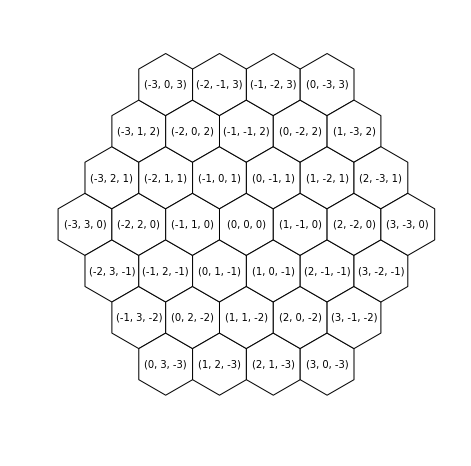

In [7]:
space = TractSpace(3)
space.plot()

Let's try a test case to help make sure we have this right: create a callback that tells us whether a tract is a neighbor of (3,-2,-1).

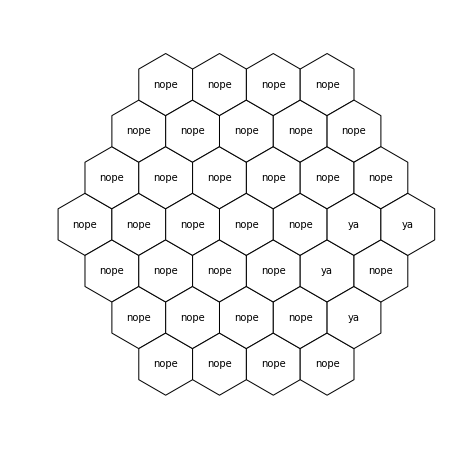

In [8]:
callback = lambda t:("nope","ya")[t in space.neighbors(3, -2, -1)]

space = TractSpace(3)
space.plot(callback)

Well, that worked better than I expected. So now we have a mechanism for creating a set of dicts that we can use to store info and keep them having some kind of spatial arrangement that allows for neighbors to be found. Let's create some filaments and cross-linkers to populate those dicts with. And let's figure out a way to display all those guys.

In [9]:
class BindingSite:
    """An actin binding site"""
    def __init__(self, filament, x):
        self.filament = filament
        self.x = x
        self.xlinker = None
        
class Actin:
    """A 1D actin"""
    def __init__(self, x, n, t):
        """An actin at x with n pairs of g-actin on tract t"""
        self.x = x
        self.pairs = n
        self._rise = 2.77 #nm per actin pair
        self.sites = [BindingSite(self, x+i*self._rise) for i in range(n)]
        
    @property
    def length(self):
        """How long are you?"""
        return abs(self.pairs * self._rise)
    
    @property
    def bounds(self):
        """How far do you extend?"""
        return (self.x, self.x+self.length)
    
    @property
    def site_x(self):
        """Where are the sites?"""
        return [s.x for s in self.sites]
    
    def nearest(self, x):
        """What is the nearest site to the given location"""
        return np.argmin(np.abs(np.subtract(x, [s.x for s in self.sites])))
    
    def force(self):
        """Let's assume that the filament is really stiff, like really stiff, and then find the total force on it."""
        return np.sum([np.sum([site.xlinker.force for site in self.sites if site.xlinker is not None])])
    
    def plot(self, ax=None, show=False, y=0):
        """Plot this fil"""
        if ax is None:
            fig, ax = plt.subplots(1,1,figsize=(8,8))
            ax.axis('off')
            ax.set(xlim=self.bounds, ylim=(y-2*self._rise, y+2*self._rise), aspect=1)
        circ = lambda x, y: matplotlib.patches.CirclePolygon((x, y), radius=0.66*self._rise, resolution=20,
                                                          facecolor='skyblue', edgecolor='royalblue')
        #Work through each site pair
        for x in [s.x for s in self.sites]:
            ax.add_patch(circ(x+a._rise*0.1, y+0.5*self._rise))
            ax.add_patch(circ(x-a._rise*0.1, y-0.5*self._rise))
        if show:
            plt.show()
        return ax
    
class Actinin_head:
    """One of the two heads of an alpha-actinin"""
    def __init__(self, actinin):
        self.actinin = actinin
        self.binding_site = None
        self.state = None #None or 
        
    def transition(self):
        """Move to another state?"""
        raise NotImplemented
        
    def bind_or_not(self, site):
        """Maybe bind? Can't say for sure.
        TODO: This is very very wrong
        """
        raise NotImplemented
    
    def unbind_or_not(self):
        """Maybe unbind? Can't say for sure.
        TODO: This is very very wrong
        """
        raise NotImplemented
        
    
    
class Alpha_actinin:
    """A 1D alpha-actinin"""
    def __init__(self, x):
        self.linked_sites = [None, None]
        self.x = x
    
    def diffuse(self):
        """Move about a bit"""
        # TODO: This isn't checked well at this time, CDW20190218
        # k_T = Boltzmann constant * temperature = (1.381E-23 J/K * 288 K)
        k_t = 1.381*10**-23 * 288 * 10**21 #10**21 converts J to pN*nM
        # Normalize: a factor used to normalize the PDF of the segment values
        _normalize = np.sqrt(2*np.pi*k_t/self.k_w)
        _stand_dev = np.sqrt(k_t/self.k_w) # of segment values
        
    def consider_binding(self):
        """What is your nearest binding site, do you want to bind?"""
        
     

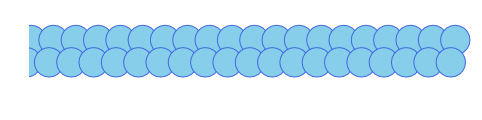

In [77]:
a = Actin(10,20,None)
a.plot(show=True);

In [24]:
import importlib
import stress_fiber
importlib.reload(stress_fiber);
importlib.reload(stress_fiber.actin)

<module 'stress_fiber.actin' from '/Users/cdavew/Dropbox/aics/repos/stress_fiber/stress_fiber/actin.py'>

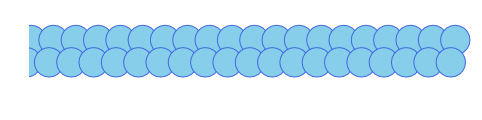

In [25]:
a = stress_fiber.actin.Actin(10, 20, None)
a.plot()